In [68]:
# Import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
import scipy.linalg as LA

from skimage import io
from skimage.transform import resize
plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

In [69]:
# Read the Brain Data and shuffle
PathDicom = "../../DataSet_Medical/Neurofeedback_Skull_stripped/NFBS_Dataset/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    if 'data' in str(dirName):
        for filename in fileList:
            if ".png" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))
                
image_resize_px = 64
train_data = np.zeros(shape=(len(lstFilesDCM),image_resize_px,image_resize_px))
for file_index in range(len(train_images)):
    train_data[file_index,:,:]   = resize(io.imread(lstFilesDCM[file_index],as_gray =True),(image_resize_px,image_resize_px),mode='constant',anti_aliasing=True)
idx = np.random.permutation(len(train_data))
train_data = train_data[idx]   
train_data = train_data.astype(np.float64).reshape(len(lstFilesDCM),-1)

In [70]:
# clear out some of the image that does not contain many of pixels
temp = []
for x in train_data:
    if x.mean() > train_data.mean():
        temp.append(x)
train_data = np.asarray(temp)    

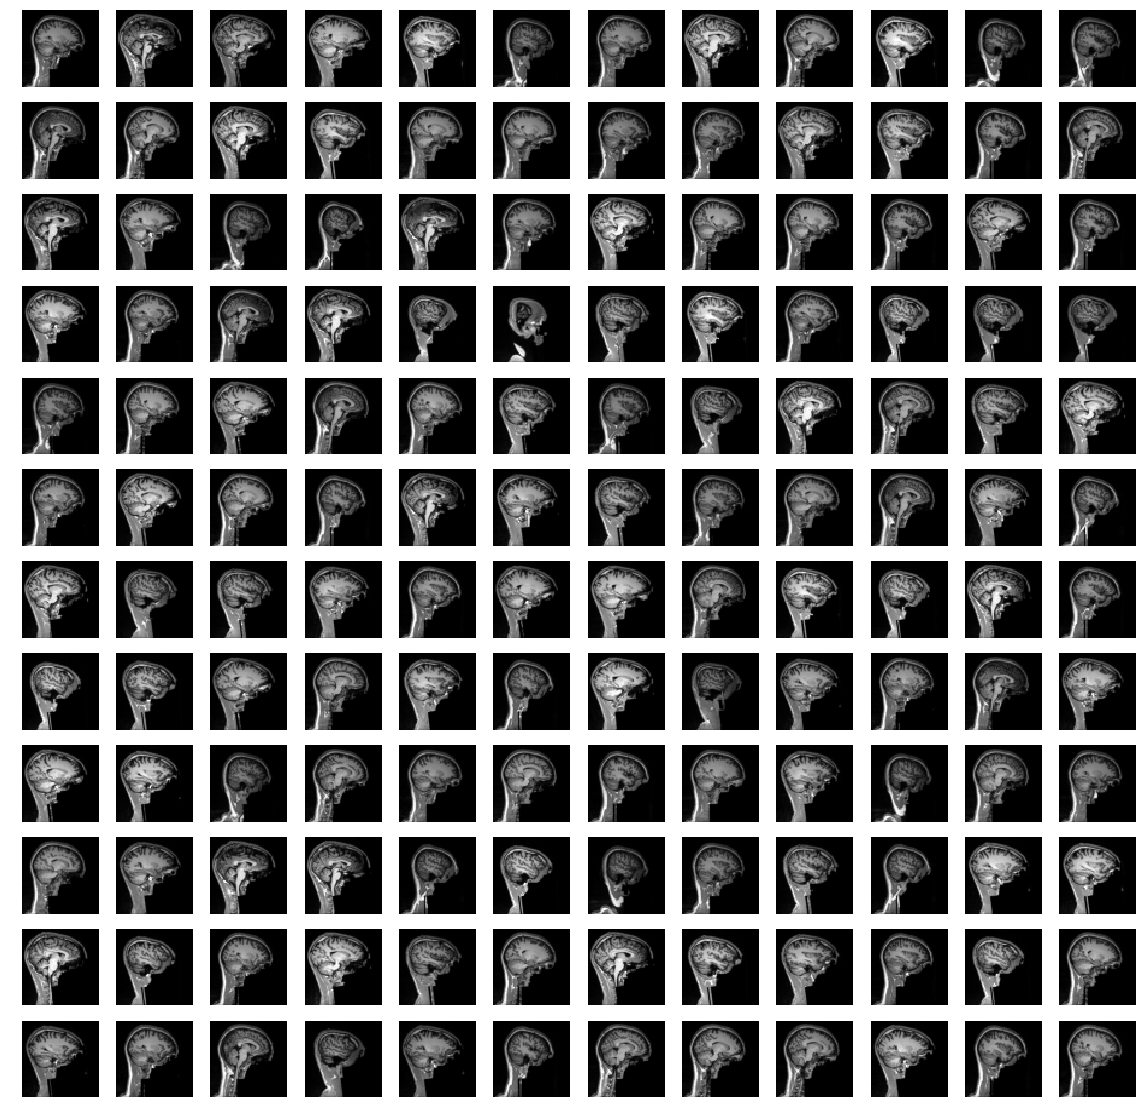

In [71]:
# view some of the data
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_data[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

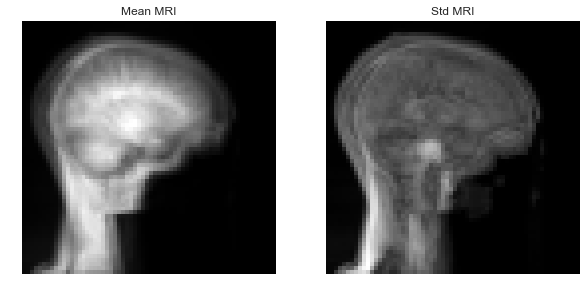

In [72]:
# center it per dimension
mean_face = train_data.mean(0); std_face = train_data.std(0)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(mean_face.reshape(64,64),cmap='gray')
plt.axis('off')
plt.title("Mean MRI")

plt.subplot(122)
plt.imshow(std_face.reshape(64,64),cmap='gray')
plt.axis('off')
plt.title("Std MRI")

plt.show()

---- After Centering -------
(207, 4096)
-0.4323076801734816 0.7532841736280151
-5.0281839883385713e-20 0.09258794779808392


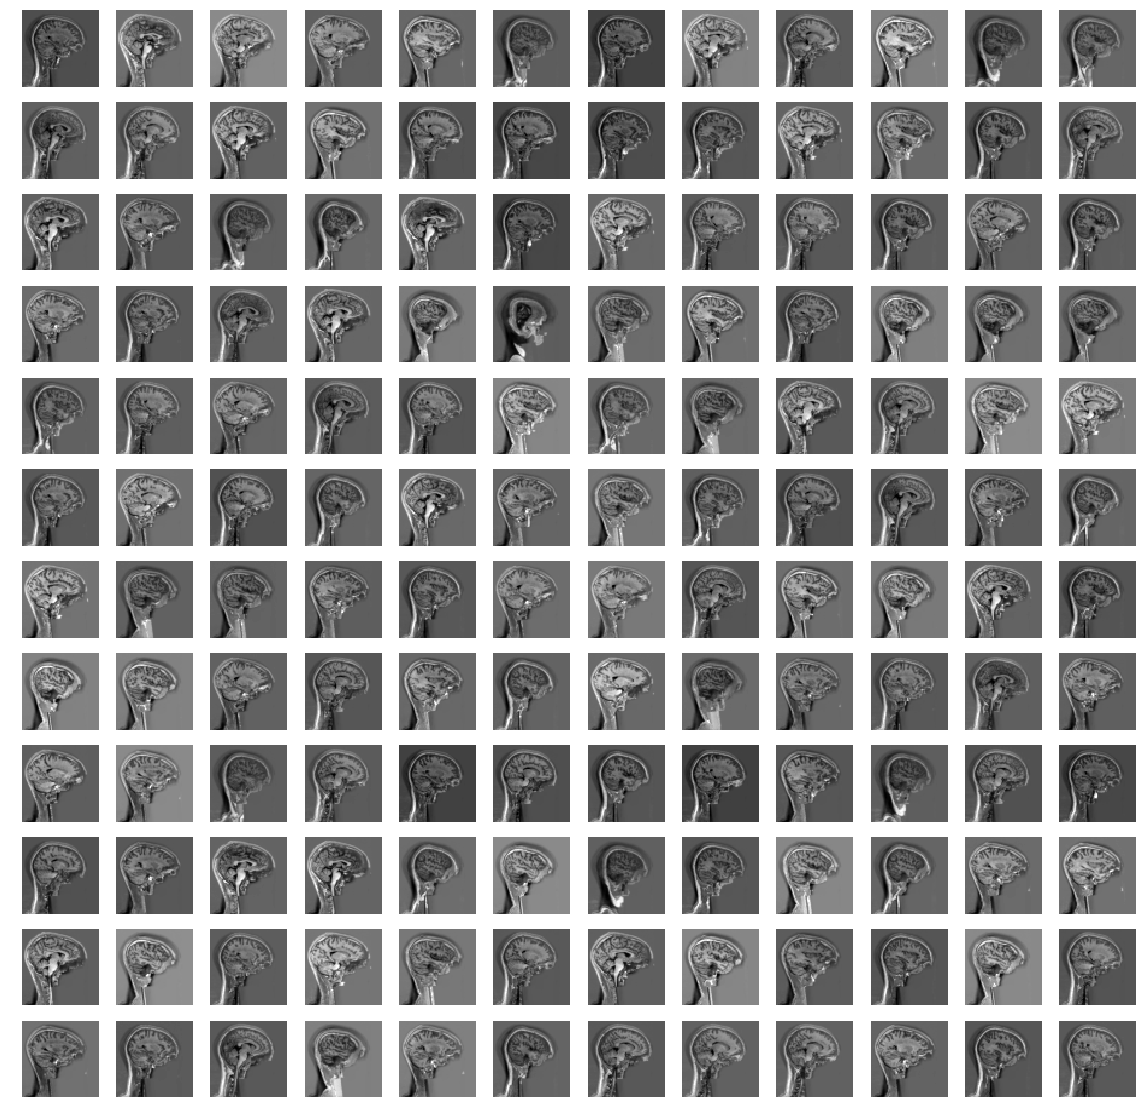

In [73]:
# center the face per dimesion and view it
centered = train_data - mean_face
print('---- After Centering -------')
print(centered.shape)
print(centered.min(),centered.max())
print(centered.mean(),centered.std())
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(centered[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

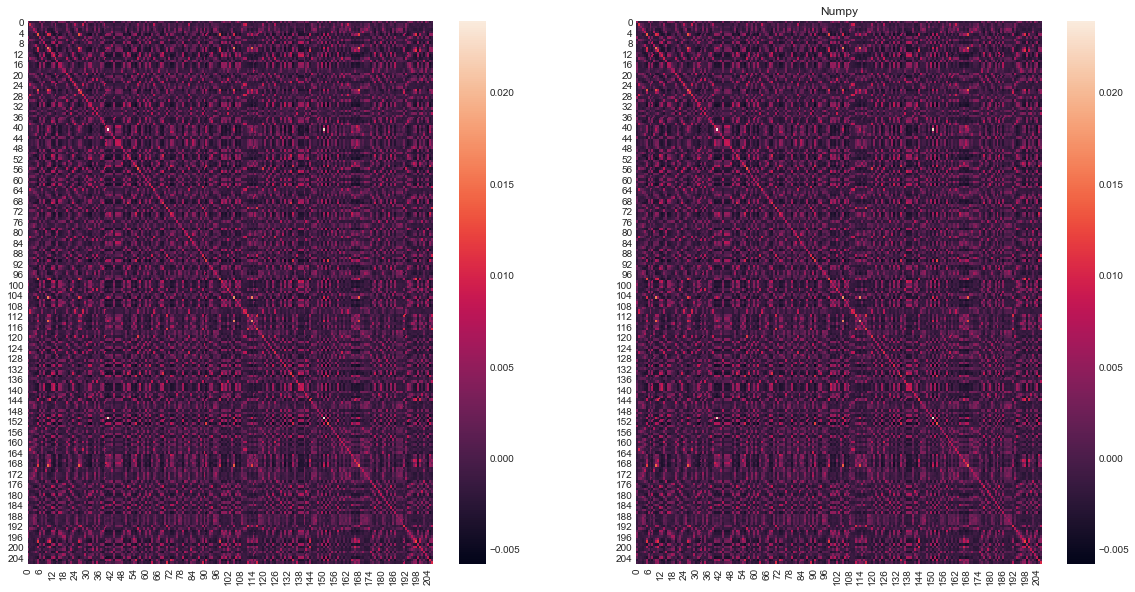

In [74]:
# calculate the co-variance 
centered_both = centered - centered.mean(1)[:,np.newaxis]
centered_both_cov = (centered_both @ centered_both.T)/centered_both.shape[1]
plt.figure(figsize=(20,10))
plt.title('Manual')
plt.subplot(121)
sns.heatmap(centered_both_cov)
plt.subplot(122)
plt.title('Numpy')
sns.heatmap(np.cov(centered,rowvar=True))
plt.show()

In [75]:
# Eigen value decomposition
evalue,evector = LA.eigh(centered_both_cov)

In [76]:
# sort the eigen values 
print('First 5 Values before sorting: ',evalue[:5])
print('Final 5 Values before sorting: ',evalue[-5:])
print('First 5 Vector Mean before sorting: ',evector[:,:5].mean())
print('Final 5 Vector Mean before sorting: ',evector[:,-5:].mean())
idx = np.argsort(evalue)[::-1]
print('-------------------------')
evalue_sort = evalue[idx]; evector_sort = evector[:,idx]
print('First 5 Values after sorting: ',evalue_sort[:5])
print('Final 5 Values after sorting: ',evalue_sort[-5:])
print('First 5 Vector Mean after sorting: ',evector_sort[:,:5].mean())
print('Final 5 Vector Mean after sorting: ',evector_sort[:,-5:].mean())

First 5 Values before sorting:  [2.15031948e-18 7.84754272e-06 8.46161217e-06 9.74342434e-06
 1.00570556e-05]
Final 5 Values before sorting:  [0.07648839 0.12434666 0.14172709 0.29341096 0.43793606]
First 5 Vector Mean before sorting:  -0.013900960937135281
Final 5 Vector Mean before sorting:  -1.5553849137260648e-18
-------------------------
First 5 Values after sorting:  [0.43793606 0.29341096 0.14172709 0.12434666 0.07648839]
Final 5 Values after sorting:  [1.00570556e-05 9.74342434e-06 8.46161217e-06 7.84754272e-06
 2.15031948e-18]
First 5 Vector Mean after sorting:  -1.2603981197435351e-18
Final 5 Vector Mean after sorting:  -0.013900960937135281


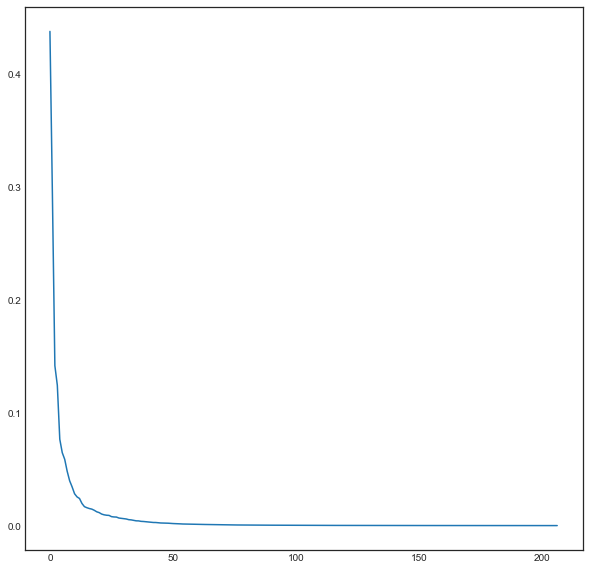

Original Eig Vector:  (207, 207)
Selected Eig Vector:  (207, 50)


In [77]:
# plot the variance of e value select 50 eigen vectors
plt.figure(figsize=(10,10))
plt.plot(evalue_sort)
plt.show()
evector_sort_small = evector_sort[:,:50]
print('Original Eig Vector: ',evector_sort.shape)
print('Selected Eig Vector: ',evector_sort_small.shape)

Reduced data Shape : (50, 4096)


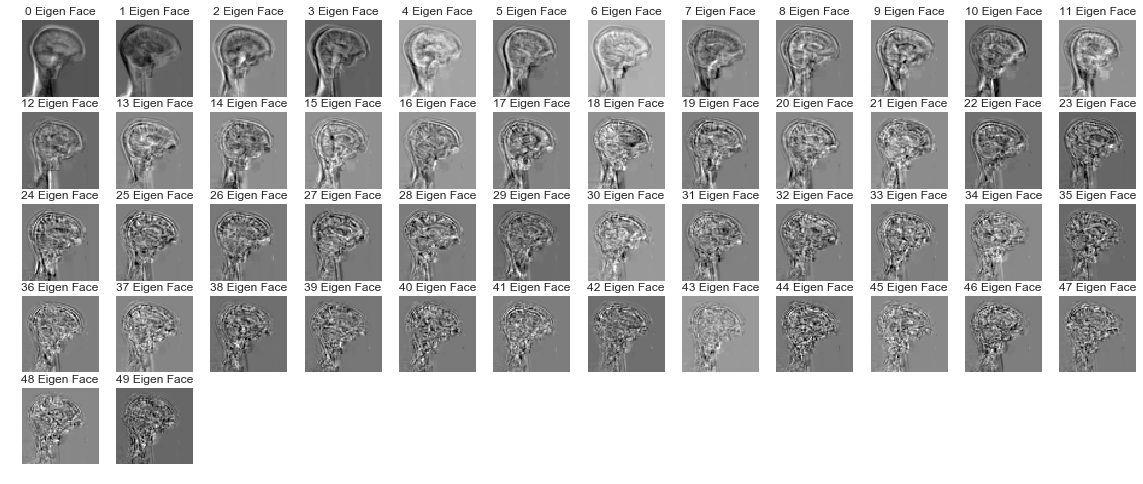

In [78]:
# project the normalized centered data to sub space
sub_centered = evector_sort_small.T @ centered_both
print('Reduced data Shape :',sub_centered.shape)
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    try: 
        sub_centered[i-1].all()
        fig.add_subplot(rows, columns, i)
        plt.imshow(sub_centered[i-1].reshape(64,64),cmap='gray')
        plt.axis('off')
        plt.title(str(i-1) + ' Eigen Face')
    except:
        pass
plt.show()

Reconstructed data Shape : (50, 4096)


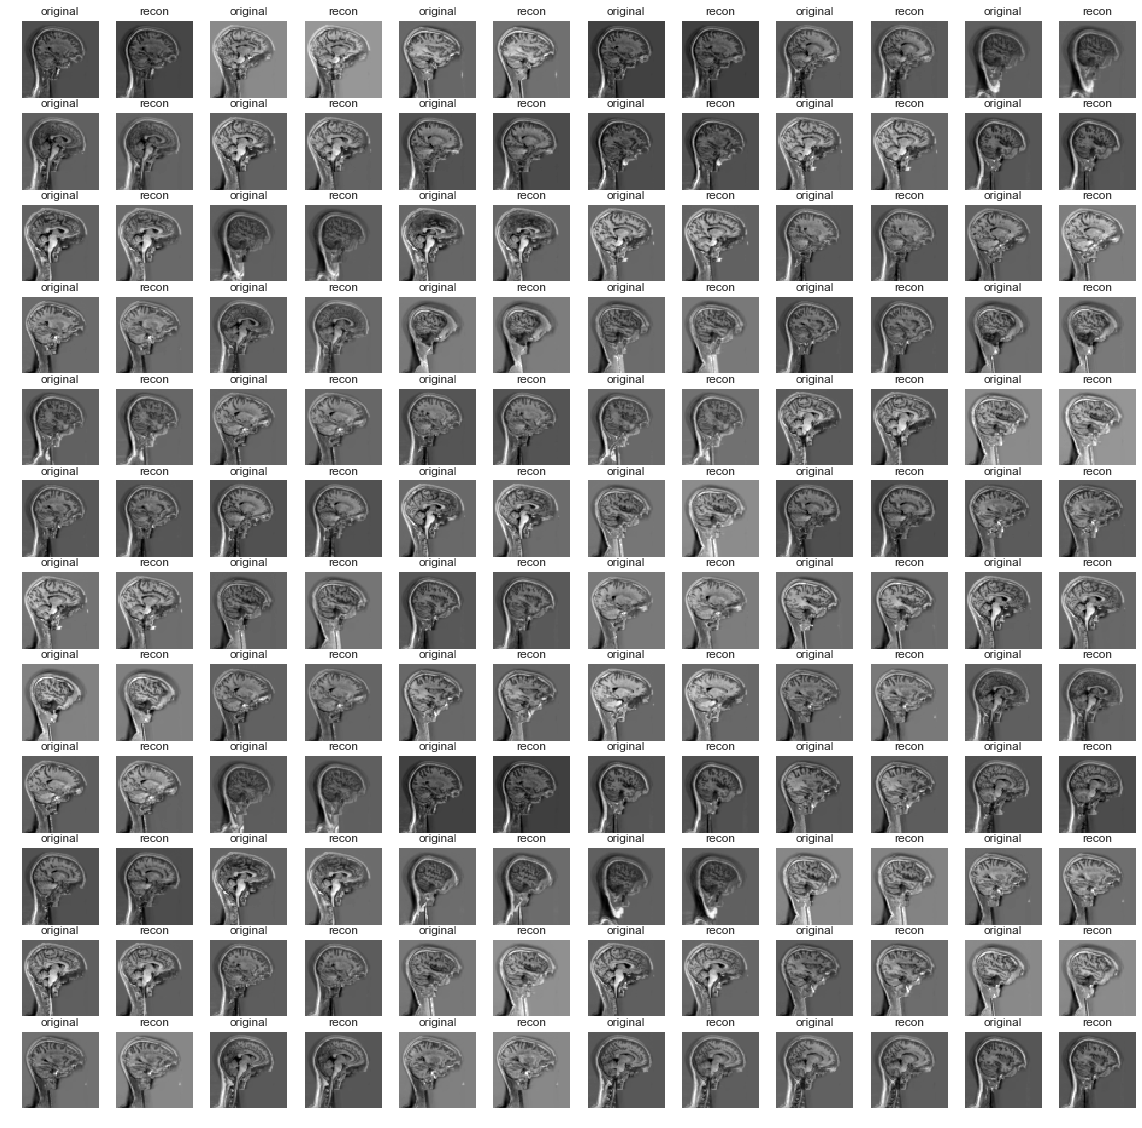

In [79]:
# Reconstruce form the small data
recon_data = evector_sort_small @ sub_centered
print('Reconstructed data Shape :',sub_centered.shape)
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if i % 2 == 0 :
        plt.title("recon")
        plt.imshow(recon_data[i-2].reshape(64,64),cmap='gray')
    else:
        plt.title("original")
        plt.imshow(centered_both[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

In [80]:
# Hyper Parameters
train_batch = sub_centered.copy()
num_epoch = 1000 ; learing_rate = 0.0001
beta1,beta2,adam_e = 0.9,0.999, 1e-8

In [81]:
# Define Class
def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FastICA_Layer():

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.005,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act
    
    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)
    
    def getw(self): return self.w
    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer
    
    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA * self.w
        grad_w_dec = self.sym_decorrelation(grad_w)
        update_w = []
        update_w.append(tf.assign(self.w,grad_w_dec))
        return update_w

In [82]:
# Define graph
x = tf.placeholder(shape=[50,4096],dtype=tf.float64)

fast_ica_layer = FastICA_Layer(50,50,tf_logcosh,d_tf_logcosh)
fica = fast_ica_layer.feedforward(x)
fica_w_update = fast_ica_layer.backprop_ica()

In [83]:
# Define Session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for iter in range(num_epoch):
    sess_results = sess.run([fica,fica_w_update],feed_dict={x:sub_centered})
    print('Iter: ',iter,' mean fica: ',sess_results[0].mean())

Iter:  0  mean fica:  1.6479873021779668e-19
Iter:  1  mean fica:  -7.003946034256359e-19
Iter:  2  mean fica:  6.136584296267955e-19
Iter:  3  mean fica:  6.928051882182373e-19
Iter:  4  mean fica:  3.5561831257524543e-19
Iter:  5  mean fica:  -2.3527187142935445e-19
Iter:  6  mean fica:  1.1232334506949825e-18
Iter:  7  mean fica:  1.0055975149803054e-18
Iter:  8  mean fica:  -5.637851296924623e-20
Iter:  9  mean fica:  1.0798653637955625e-18
Iter:  10  mean fica:  -1.0701075442431928e-18
Iter:  11  mean fica:  -1.3877787807814457e-19
Iter:  12  mean fica:  9.389190813724469e-19
Iter:  13  mean fica:  -6.245004513516505e-19
Iter:  14  mean fica:  4.2609145378680326e-19
Iter:  15  mean fica:  3.903127820947816e-20
Iter:  16  mean fica:  2.222614453595284e-19
Iter:  17  mean fica:  -4.748805515486509e-19
Iter:  18  mean fica:  1.1492543028346348e-19
Iter:  19  mean fica:  7.806255641895632e-20
Iter:  20  mean fica:  -1.235990476633475e-19
Iter:  21  mean fica:  5.269222558279552e-19
It

Iter:  185  mean fica:  -2.2985086056692695e-19
Iter:  186  mean fica:  3.5128150388530346e-19
Iter:  187  mean fica:  5.334274688628682e-19
Iter:  188  mean fica:  6.396792817664477e-19
Iter:  189  mean fica:  6.982261990806649e-19
Iter:  190  mean fica:  8.782037597132586e-19
Iter:  191  mean fica:  1.3509159069169386e-18
Iter:  192  mean fica:  1.3314002678121994e-18
Iter:  193  mean fica:  4.401860820291148e-19
Iter:  194  mean fica:  2.38524477946811e-19
Iter:  195  mean fica:  5.551115123125783e-19
Iter:  196  mean fica:  -4.87890977618477e-19
Iter:  197  mean fica:  8.716985466783455e-19
Iter:  198  mean fica:  1.4094628242311558e-19
Iter:  199  mean fica:  1.5178830414797062e-18
Iter:  200  mean fica:  8.413408858487514e-19
Iter:  201  mean fica:  1.0408340855860842e-19
Iter:  202  mean fica:  3.0791341698588324e-19
Iter:  203  mean fica:  3.924811864397526e-19
Iter:  204  mean fica:  -3.3393426912553537e-19
Iter:  205  mean fica:  -3.5128150388530346e-19
Iter:  206  mean fica:

Iter:  362  mean fica:  1.1557595158695477e-18
Iter:  363  mean fica:  -4.119968255444917e-20
Iter:  364  mean fica:  7.437626903250561e-19
Iter:  365  mean fica:  6.114900252818245e-19
Iter:  366  mean fica:  2.732189474663471e-19
Iter:  367  mean fica:  4.3151246464923076e-19
Iter:  368  mean fica:  2.1467203015212988e-19
Iter:  369  mean fica:  1.0842021724855045e-20
Iter:  370  mean fica:  5.702903427273753e-19
Iter:  371  mean fica:  1.734723475976807e-20
Iter:  372  mean fica:  2.7972416050126015e-19
Iter:  373  mean fica:  1.2793585635328952e-19
Iter:  374  mean fica:  7.199102425303749e-19
Iter:  375  mean fica:  9.291612618200773e-19
Iter:  376  mean fica:  -4.466912950640278e-19
Iter:  377  mean fica:  1.9949319973733282e-19
Iter:  378  mean fica:  5.149960319306146e-19
Iter:  379  mean fica:  2.45029690981724e-19
Iter:  380  mean fica:  1.9840899756484732e-19
Iter:  381  mean fica:  6.635317295611287e-19
Iter:  382  mean fica:  4.445228907190568e-19
Iter:  383  mean fica:  -

Iter:  542  mean fica:  4.174178364069192e-19
Iter:  543  mean fica:  -2.2768245622195592e-20
Iter:  544  mean fica:  -7.372574772901431e-20
Iter:  545  mean fica:  1.4094628242311558e-19
Iter:  546  mean fica:  -3.252606517456513e-21
Iter:  547  mean fica:  -1.5612511283791263e-19
Iter:  548  mean fica:  3.7621815385247006e-19
Iter:  549  mean fica:  6.830473686658678e-20
Iter:  550  mean fica:  1.2002118049414534e-18
Iter:  551  mean fica:  1.2435798918408737e-18
Iter:  552  mean fica:  3.7838655819744107e-19
Iter:  553  mean fica:  -7.914675859144182e-20
Iter:  554  mean fica:  6.938893903907229e-20
Iter:  555  mean fica:  3.3393426912553537e-19
Iter:  556  mean fica:  1.463672932855431e-19
Iter:  557  mean fica:  4.130810277169772e-19
Iter:  558  mean fica:  2.2985086056692695e-19
Iter:  559  mean fica:  -2.5261910618912254e-19
Iter:  560  mean fica:  -4.0874421902703517e-19
Iter:  561  mean fica:  2.439454888092385e-19
Iter:  562  mean fica:  -9.540979117872439e-20
Iter:  563  mea

Iter:  725  mean fica:  8.131516293641283e-19
Iter:  726  mean fica:  -1.192622389734055e-19
Iter:  727  mean fica:  5.486062992776652e-19
Iter:  728  mean fica:  5.637851296924623e-19
Iter:  729  mean fica:  4.0982842119952065e-19
Iter:  730  mean fica:  1.929879867024198e-19
Iter:  731  mean fica:  -5.323432666903827e-19
Iter:  732  mean fica:  2.168404344971009e-20
Iter:  733  mean fica:  1.2262326570811056e-18
Iter:  734  mean fica:  6.375108774214766e-19
Iter:  735  mean fica:  -6.689527404235562e-19
Iter:  736  mean fica:  -1.0191500421363741e-19
Iter:  737  mean fica:  5.117434254131581e-19
Iter:  738  mean fica:  -1.8431436932253575e-19
Iter:  739  mean fica:  4.488596994089988e-19
Iter:  740  mean fica:  -2.200930410145574e-19
Iter:  741  mean fica:  -4.0115480381963666e-19
Iter:  742  mean fica:  2.8080836267374563e-19
Iter:  743  mean fica:  4.672911363412524e-19
Iter:  744  mean fica:  7.871307772244762e-19
Iter:  745  mean fica:  5.063224145507306e-19
Iter:  746  mean fica

Iter:  904  mean fica:  8.023096076392733e-19
Iter:  905  mean fica:  3.5453411040275995e-19
Iter:  906  mean fica:  -2.7755575615628914e-19
Iter:  907  mean fica:  1.0451708942760263e-18
Iter:  908  mean fica:  5.865533753146579e-19
Iter:  909  mean fica:  8.857931749206571e-19
Iter:  910  mean fica:  4.054916125095787e-19
Iter:  911  mean fica:  3.5887091909270197e-19
Iter:  912  mean fica:  -5.204170427930421e-20
Iter:  913  mean fica:  -1.951563910473908e-20
Iter:  914  mean fica:  6.158268339717665e-19
Iter:  915  mean fica:  -1.4094628242311558e-19
Iter:  916  mean fica:  5.833007687972014e-19
Iter:  917  mean fica:  1.962405932198763e-19
Iter:  918  mean fica:  2.8189256484623116e-20
Iter:  919  mean fica:  -4.347650711666873e-19
Iter:  920  mean fica:  5.702903427273753e-19
Iter:  921  mean fica:  7.068998164605488e-19
Iter:  922  mean fica:  5.724587470723464e-19
Iter:  923  mean fica:  1.3660947373317356e-19
Iter:  924  mean fica:  1.929879867024198e-19
Iter:  925  mean fica:

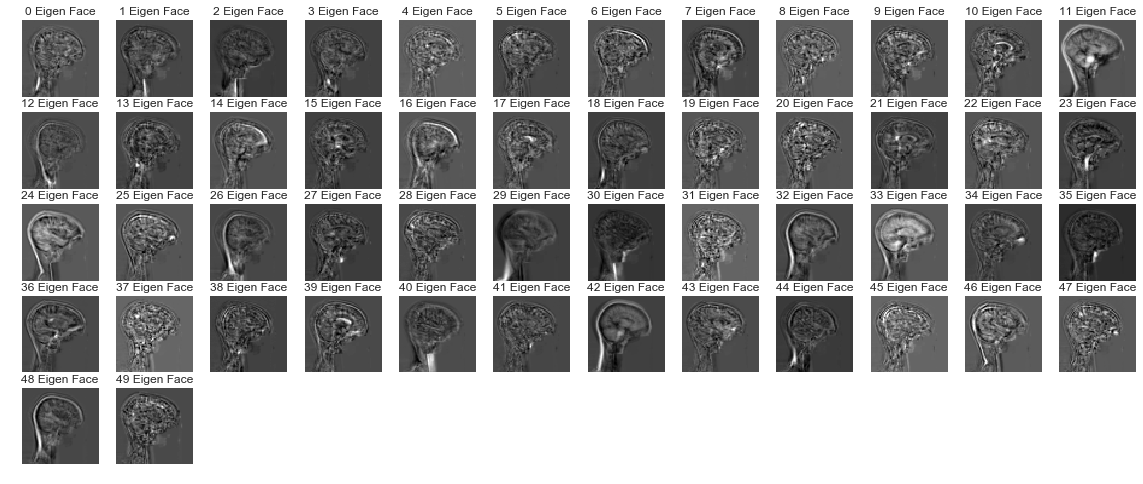

In [84]:
# view the indepedent images
resulted_images = sess.run(fica,feed_dict={x:sub_centered})
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    try: 
        sub_centered[i-1].all()
        fig.add_subplot(rows, columns, i)
        plt.imshow(resulted_images[i-1].reshape(64,64),cmap='gray')
        plt.axis('off')
        plt.title(str(i-1) + ' Eigen Face')
    except:
        pass
plt.show()